In [70]:
from obci_readmanager.signal_processing.smart_tags_manager import SmartTagsManager
from obci_readmanager.signal_processing.tags.smart_tag_definition import (
                    SmartTagDurationDefinition,
                    SmartTagEndTagDefinition)
from obci_readmanager.signal_processing.read_manager import ReadManager
from  scipy.signal import butter, filtfilt
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sg

plt.rcParams['figure.figsize'] = [20, 5]
plt.rcParams['figure.dpi'] = 75

In [71]:
def plotowanie(x, y, n_ch, Fs, titlex='Czas [s]', titley='Amplituda [µV]',xmin=0, xmax=0, title='Sygnał z kanału '):
    if xmin == 0:
        xmin = x[0]
    if xmax == 0:
        xmax=xmin+len(y)/Fs
    if type(n_ch) is str:
        plt.plot(x, y)
        plt.xlabel(titlex)
        plt.ylabel(titley)
        plt.title(title+str(n_ch)) 
        plt.tight_layout()
        plt.xlim(xmin, xmax)
    else:
        for ch in range(n_ch):
            plt.subplot(n_ch,1,ch+1)
            plt.plot(x, y[:,ch])
            plt.xlabel(titlex)
            plt.ylabel(titley)
            if ch == 0: plt.title(title+'prawo lewo') 
            else: plt.title(title+'gora dol') 
            plt.tight_layout()
            plt.xlim(xmin, xmax)
    plt.show()

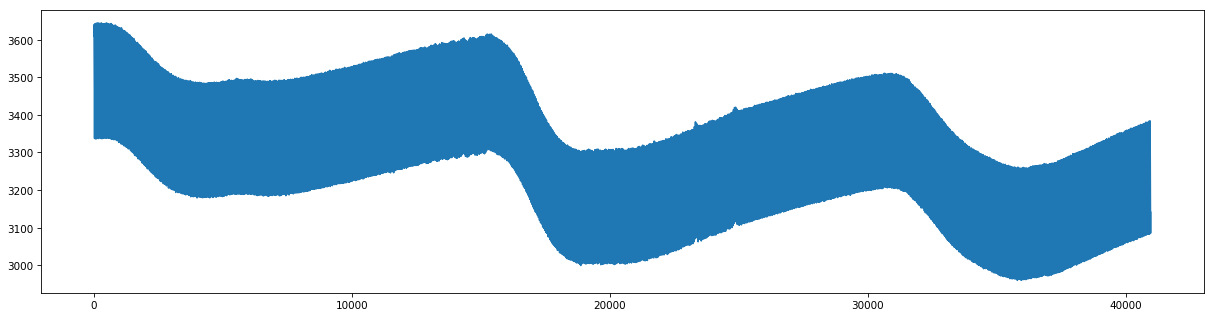

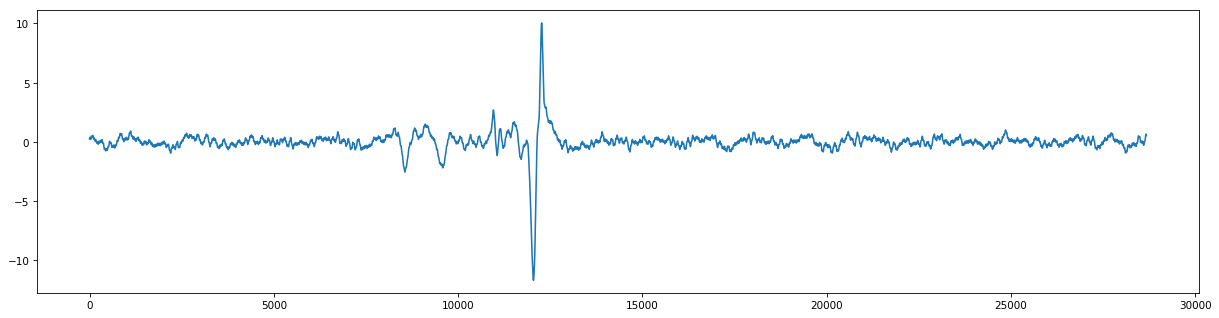

In [75]:
n_ch = 2
Fs = 2048
dt = 1/Fs
calibrationParam = 0.0715 #mikro volty na punkt

nazwaSygnalu = ['mateusz.raw']

signals = list(np.zeros(len(nazwaSygnalu)))
times = list(np.zeros(len(nazwaSygnalu)))
for i,sygnal in enumerate(nazwaSygnalu):
    with open(sygnal, 'rb') as f_out:
        s = np.fromfile(f_out, dtype='float32')
        s_mixed = np.reshape(s,(len(s)//n_ch,n_ch))
        s = s_mixed * calibrationParam
plt.plot(s[:,0][2048*180:2048*200])
plt.show()
s = s[:,0]
b,a = butter(5, 0.3/(Fs/2), btype = 'highpass')
d,c = butter(4, np.array([20])/(Fs/2), btype = 'lowpass')
syg = filtfilt(d,c,(filtfilt(b,a,s)))

# f, Pxx_spec = sg.periodogram(s)
# plt.plot(f, Pxx_spec)
plt.show()

czas = 270
plt.plot(syg[2048*czas:2048*(czas+14)])
plt.show()

2019-05-27 16:35:27,199 - smart_tags_manager - INFO - Start initialising smart tags.
2019-05-27 16:35:27,200 - smart_tags_manager - INFO - Finished initialising smart tags.
2019-05-27 16:35:27,274 - data_read_proxy - INFO - Remained sample of 154320 length (should be zero) as required length was 229376. No next value.
2019-05-27 16:35:27,275 - smart_tags_manager - INFO - No samples left. Some smart tags could have been ignored, probably 1 of 30 tags.


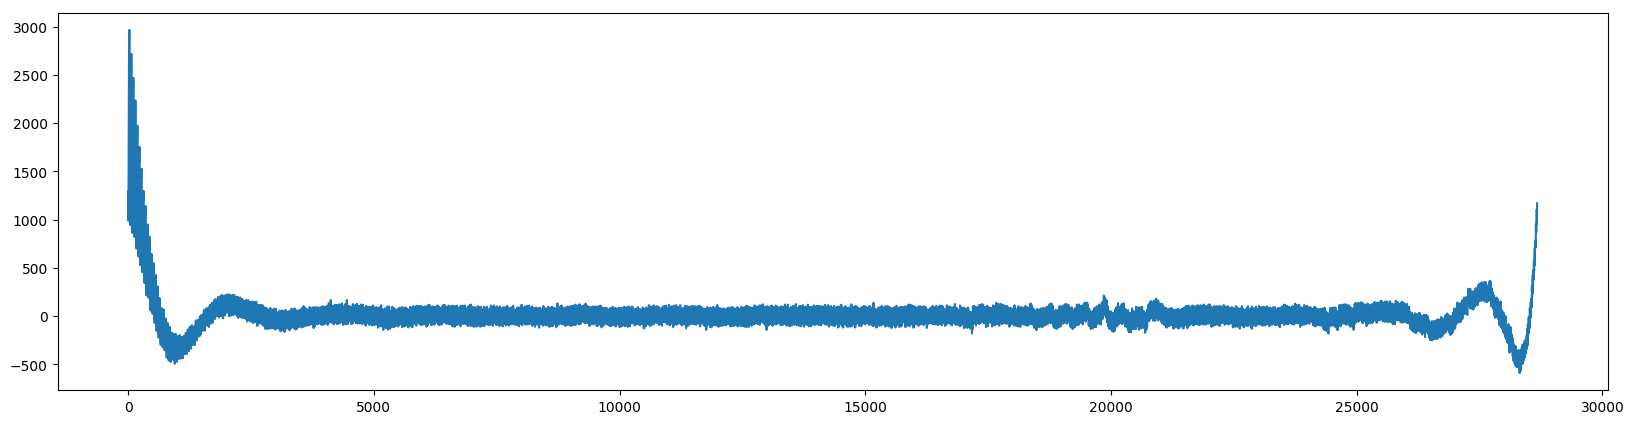

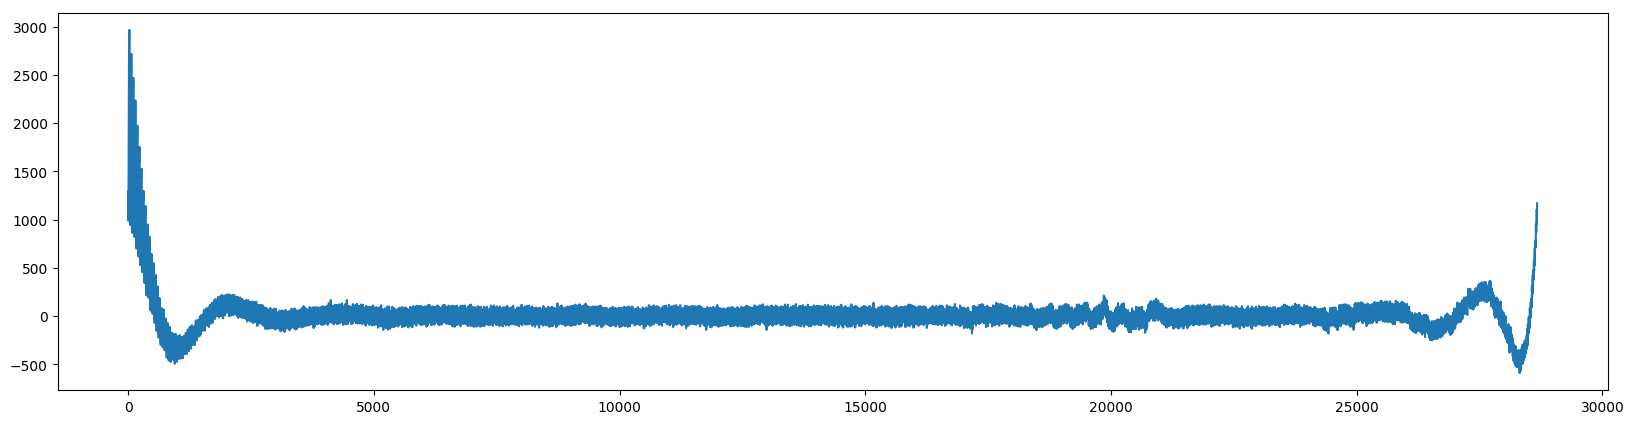

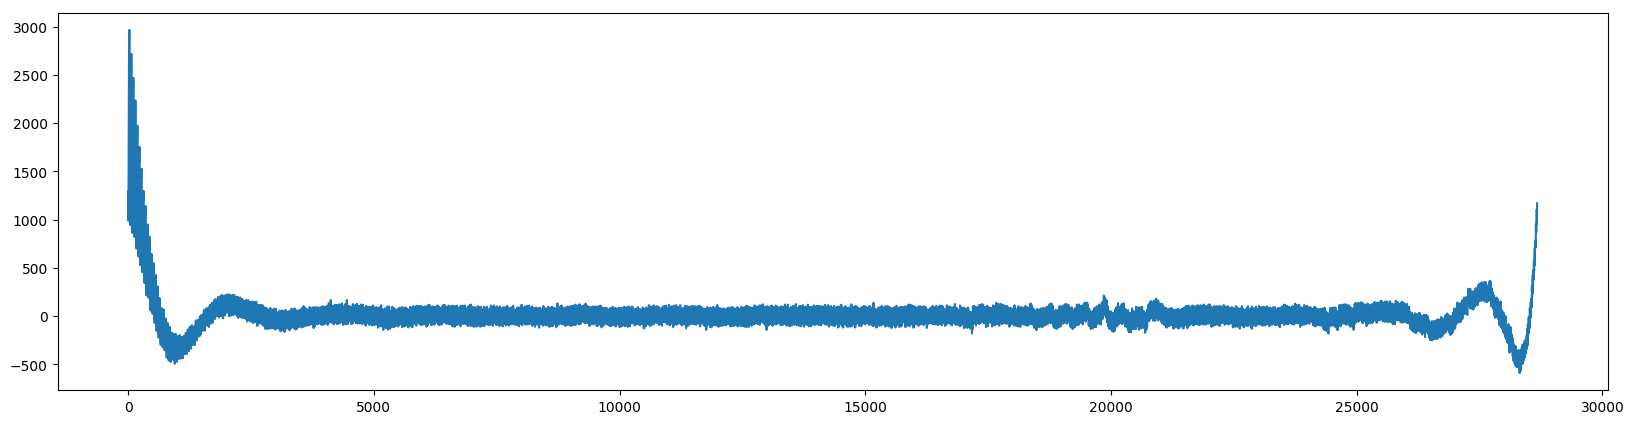

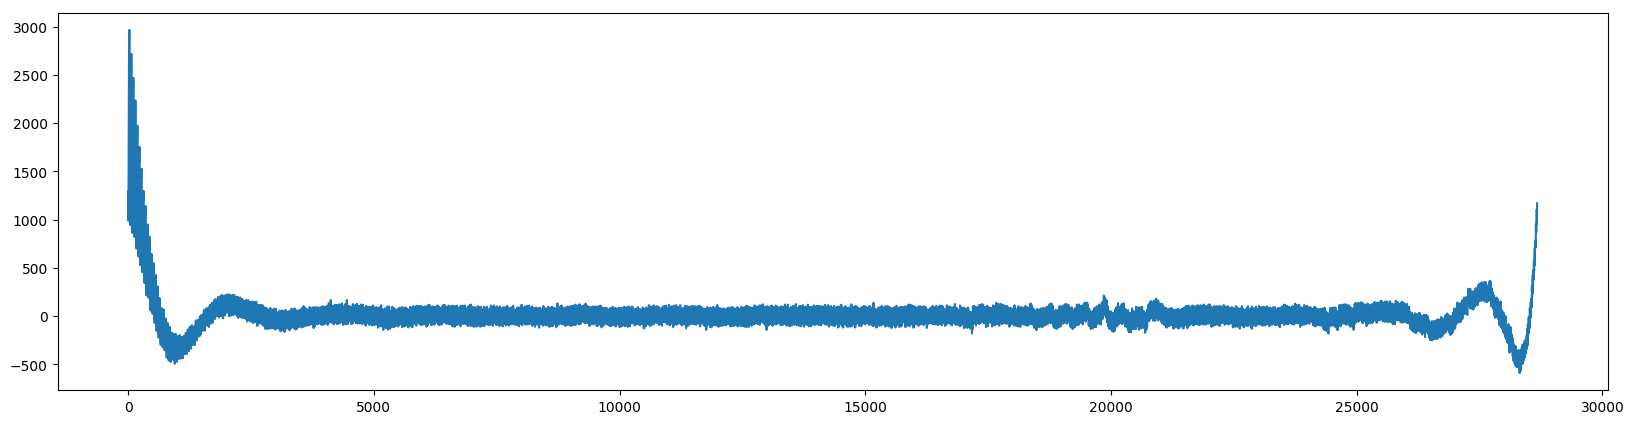

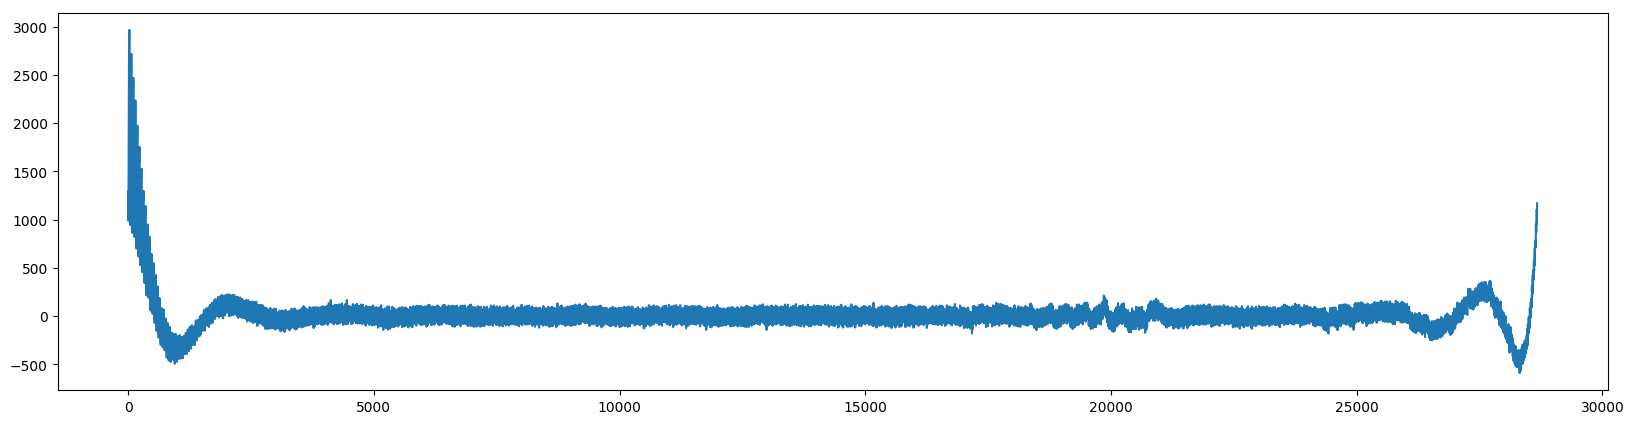

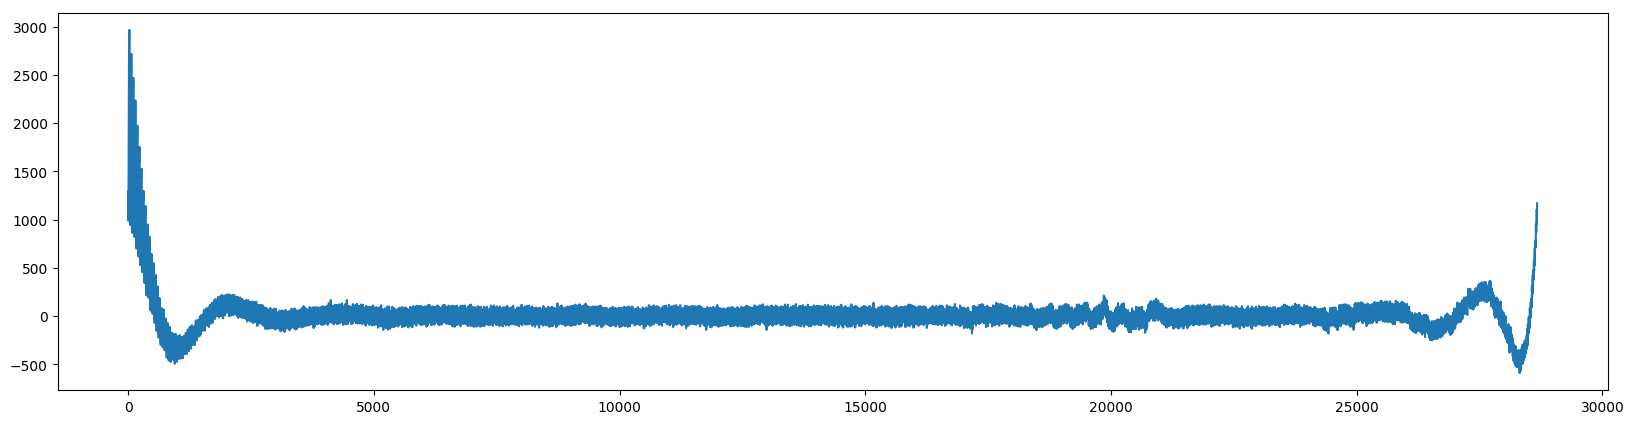

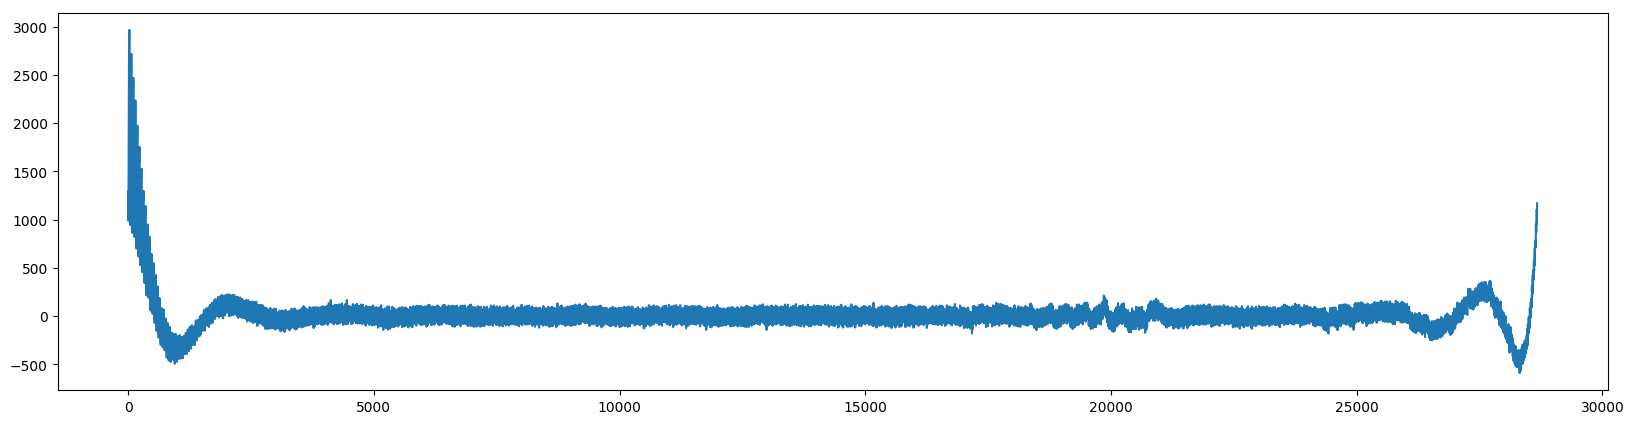

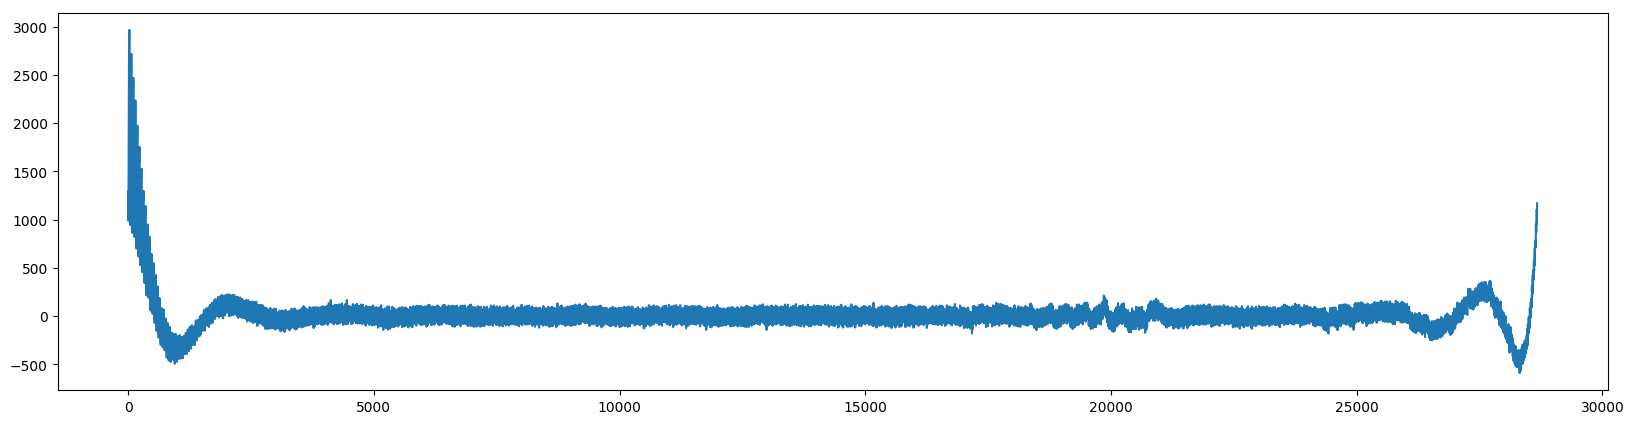

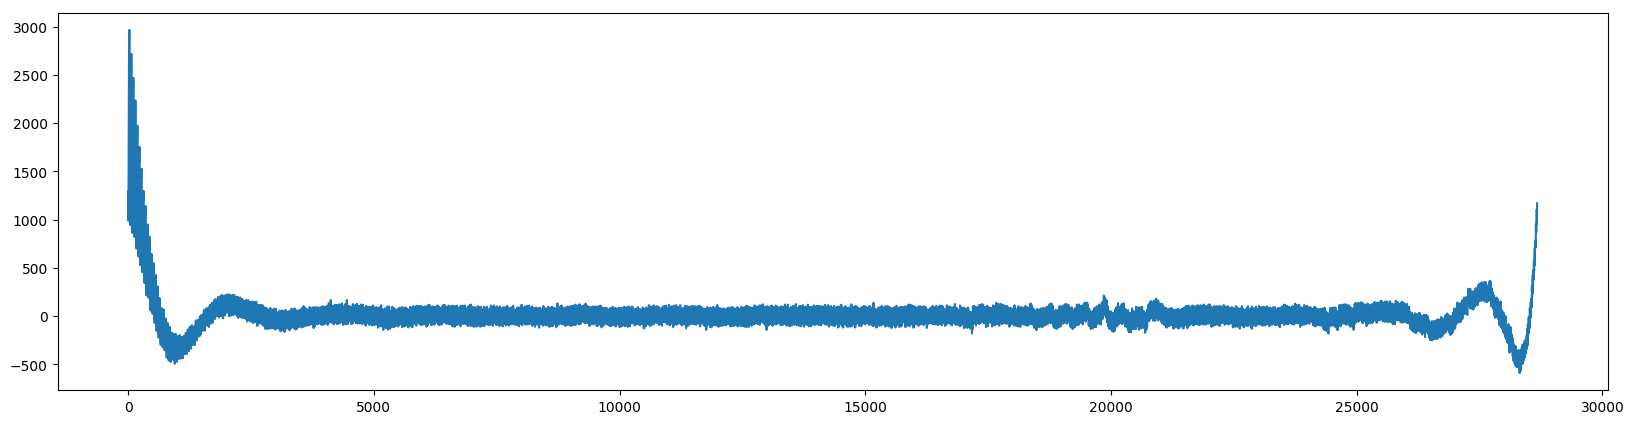

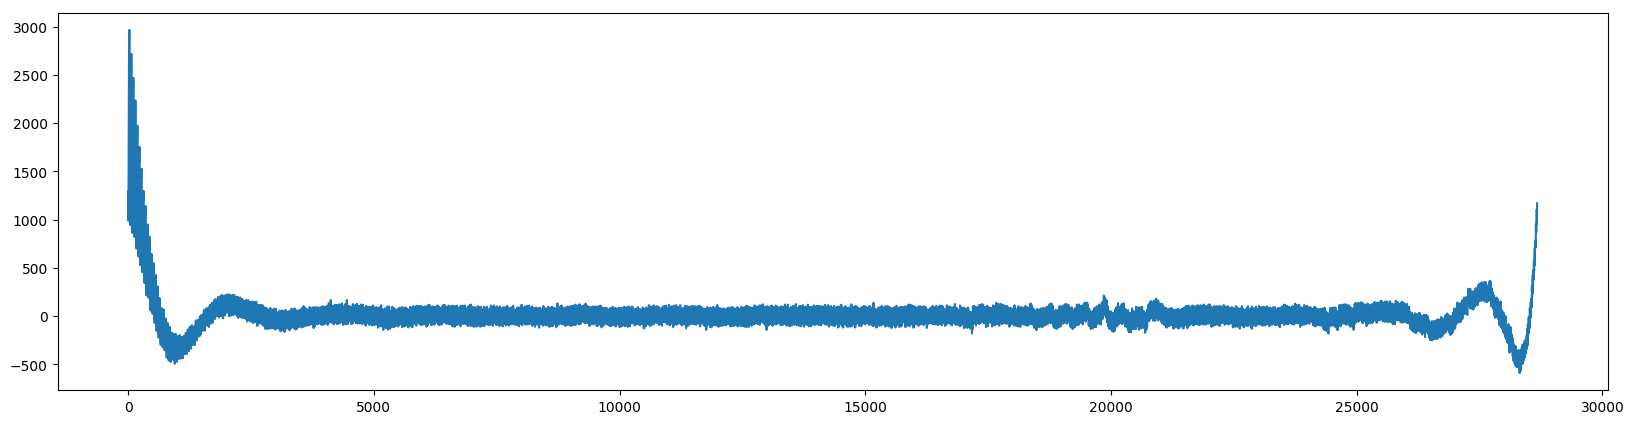

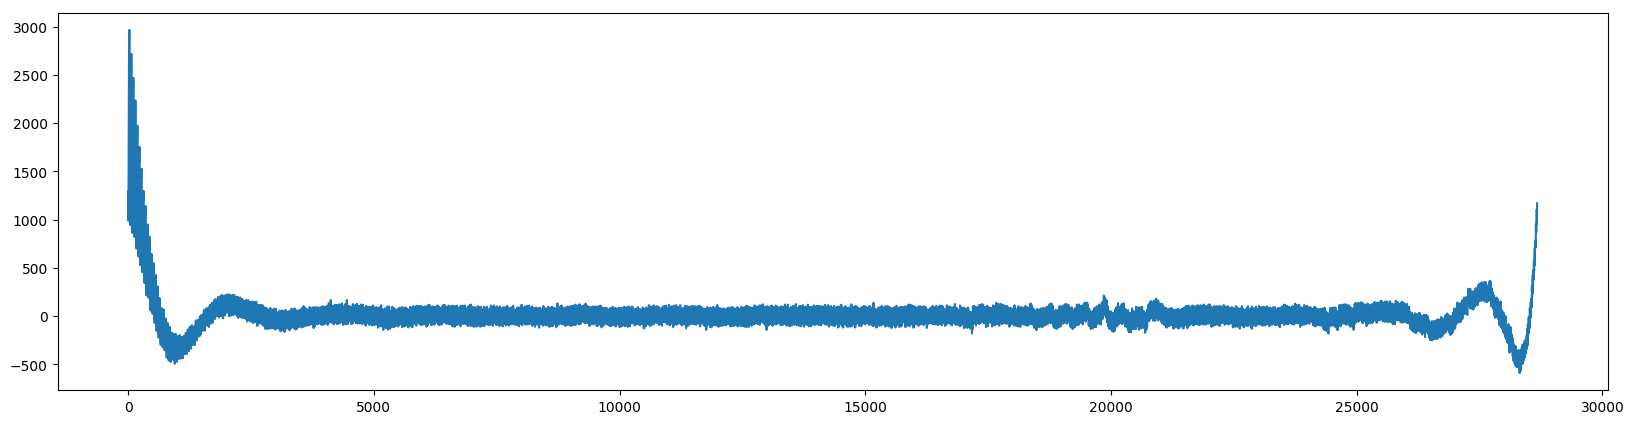

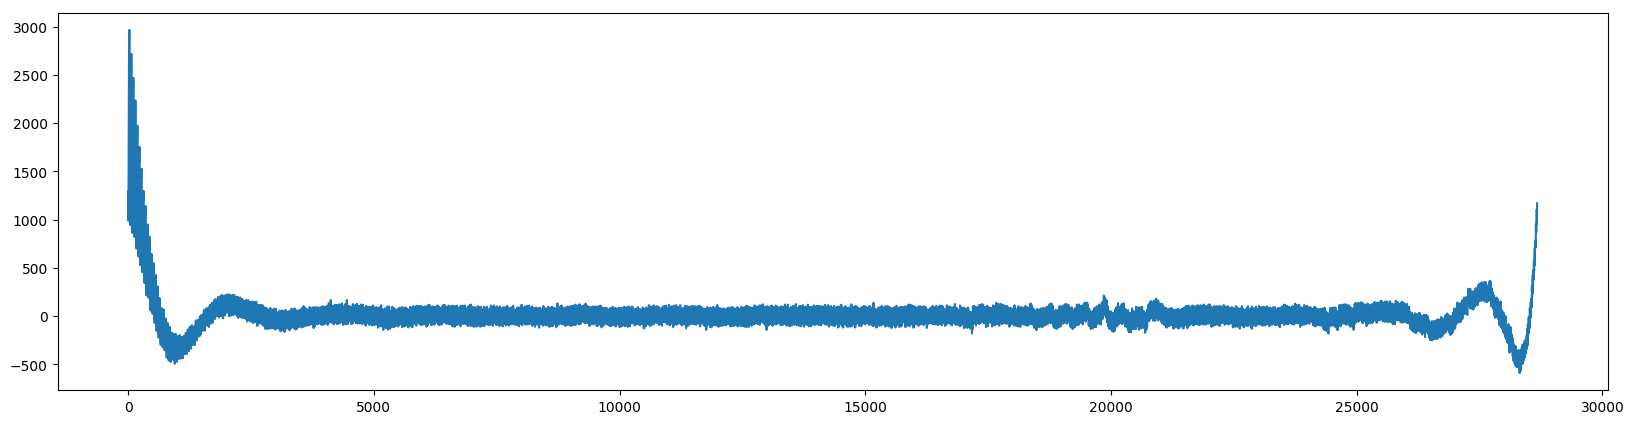

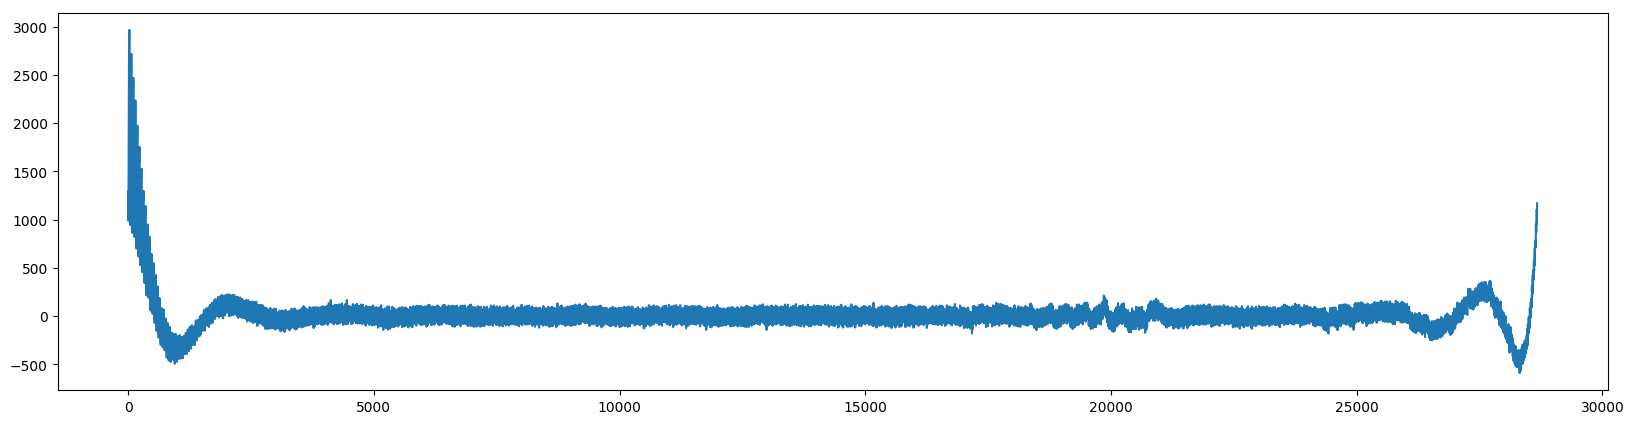

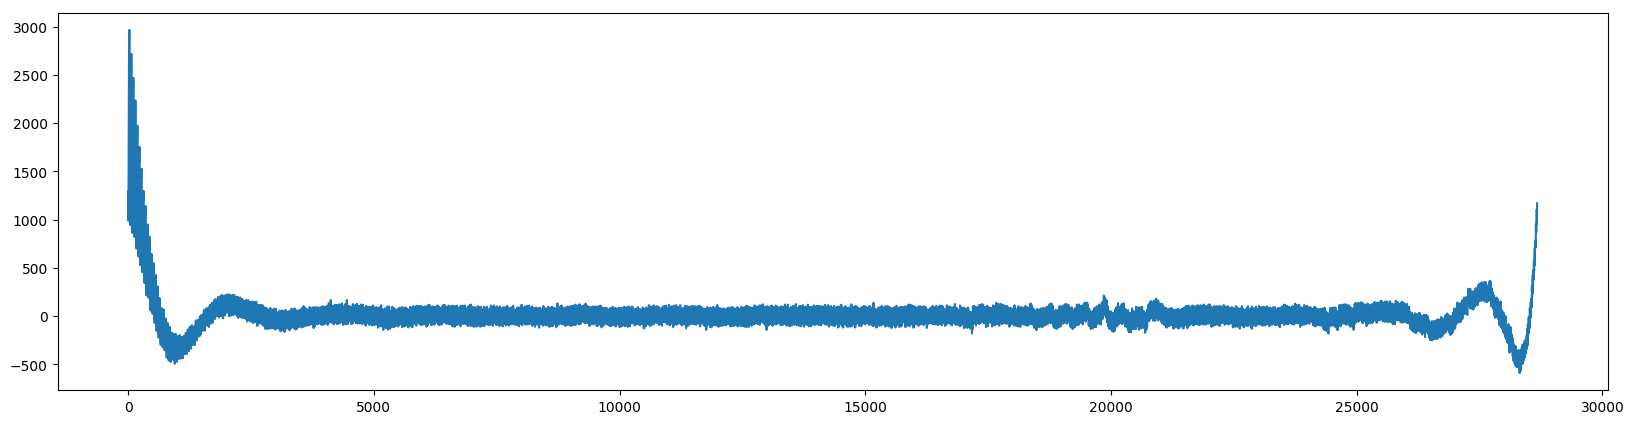

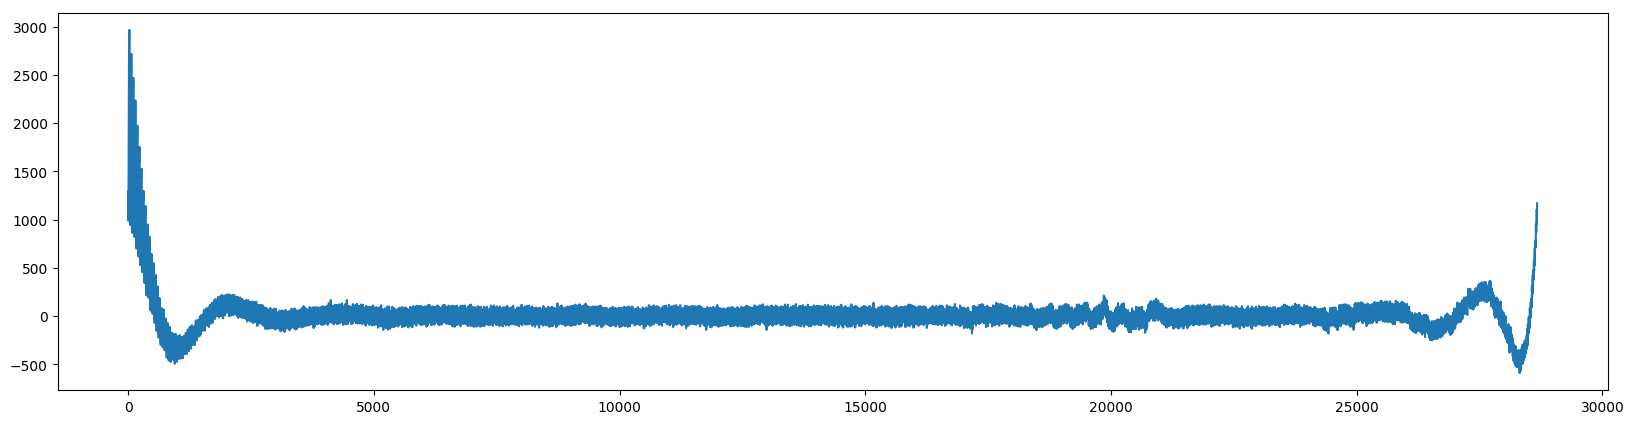

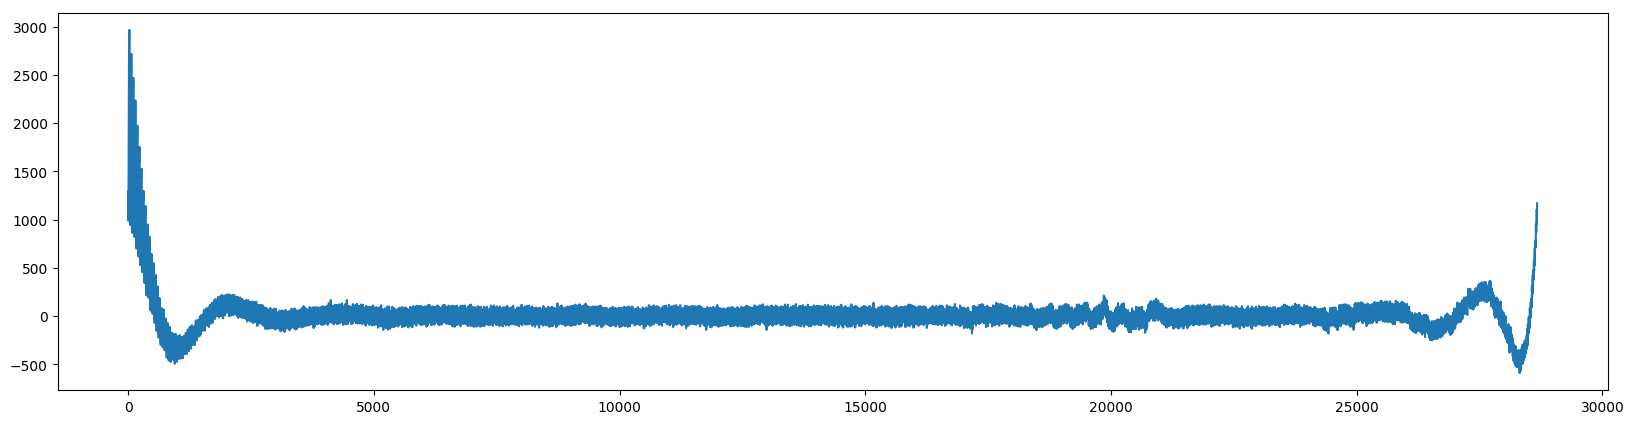

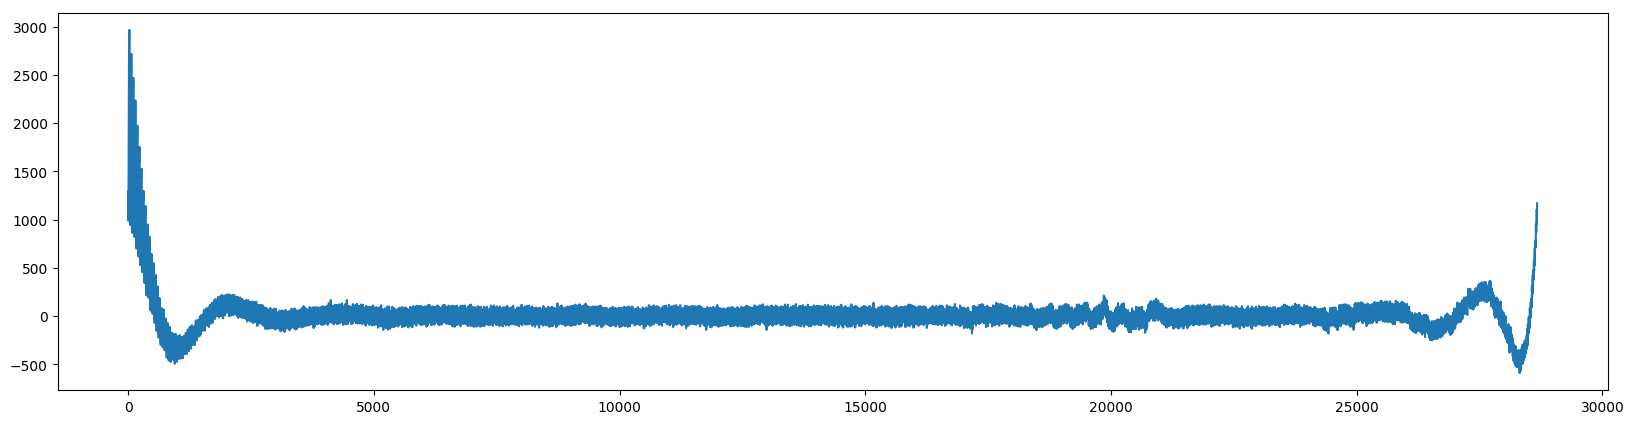

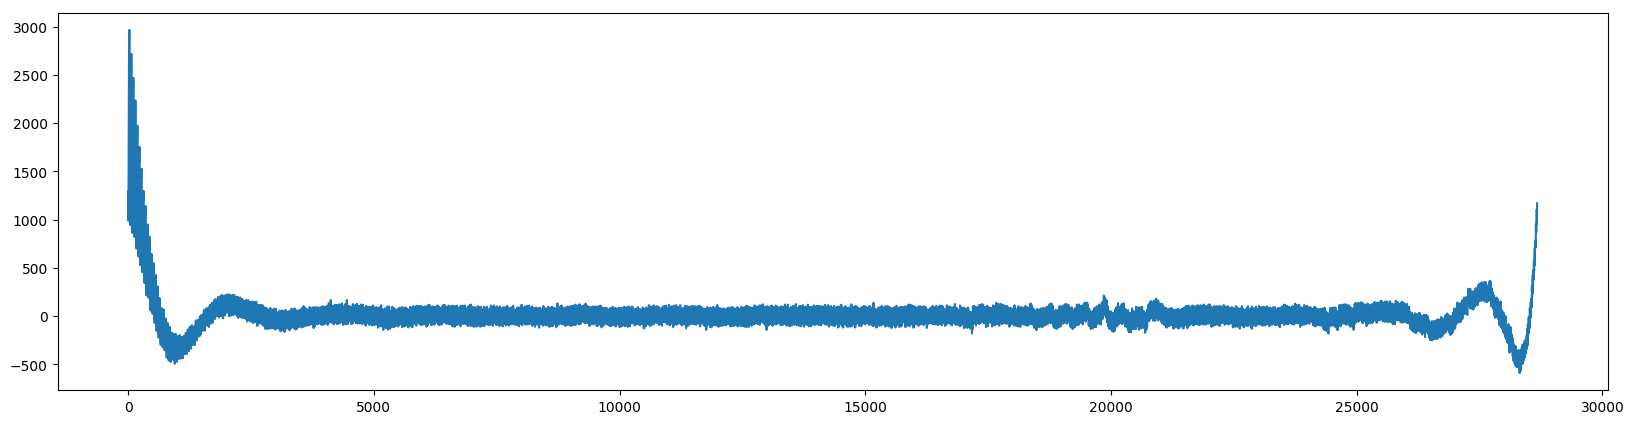

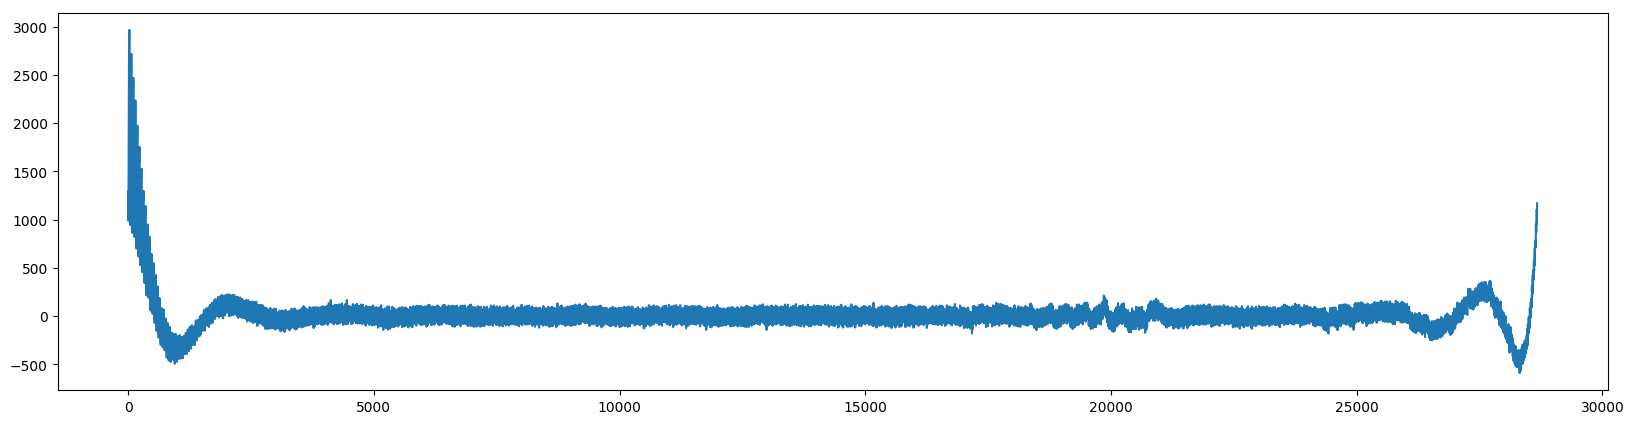

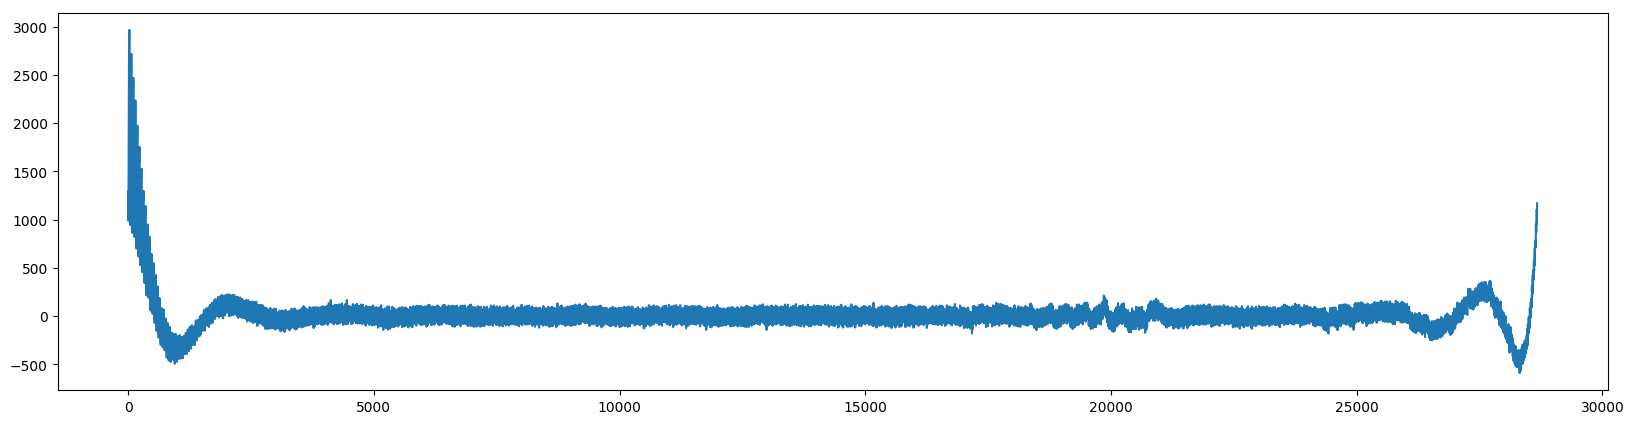

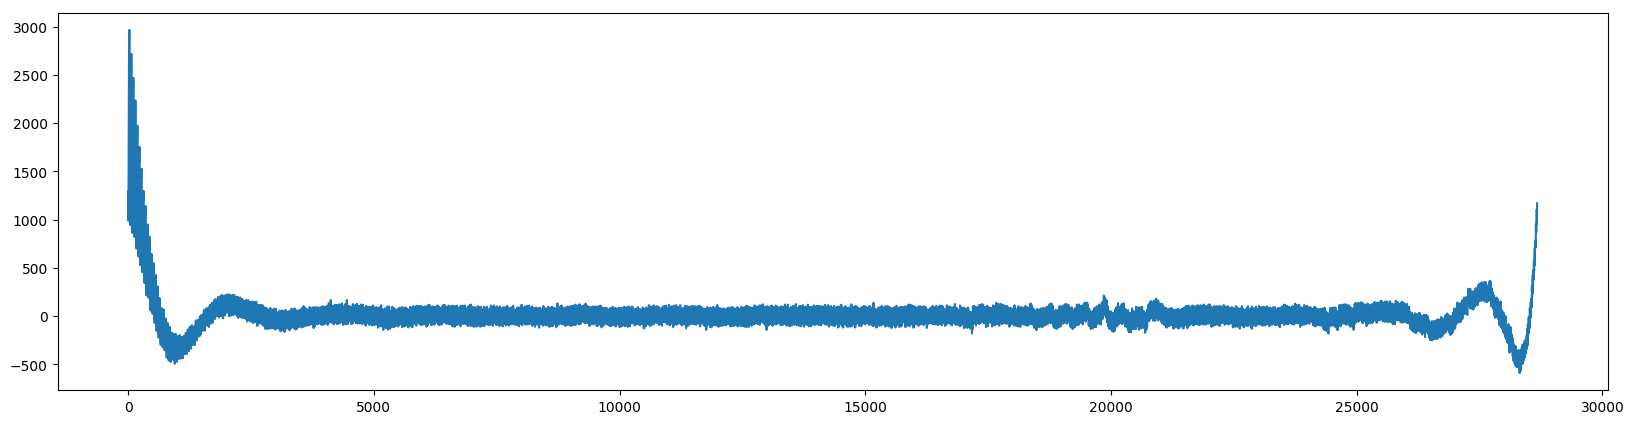

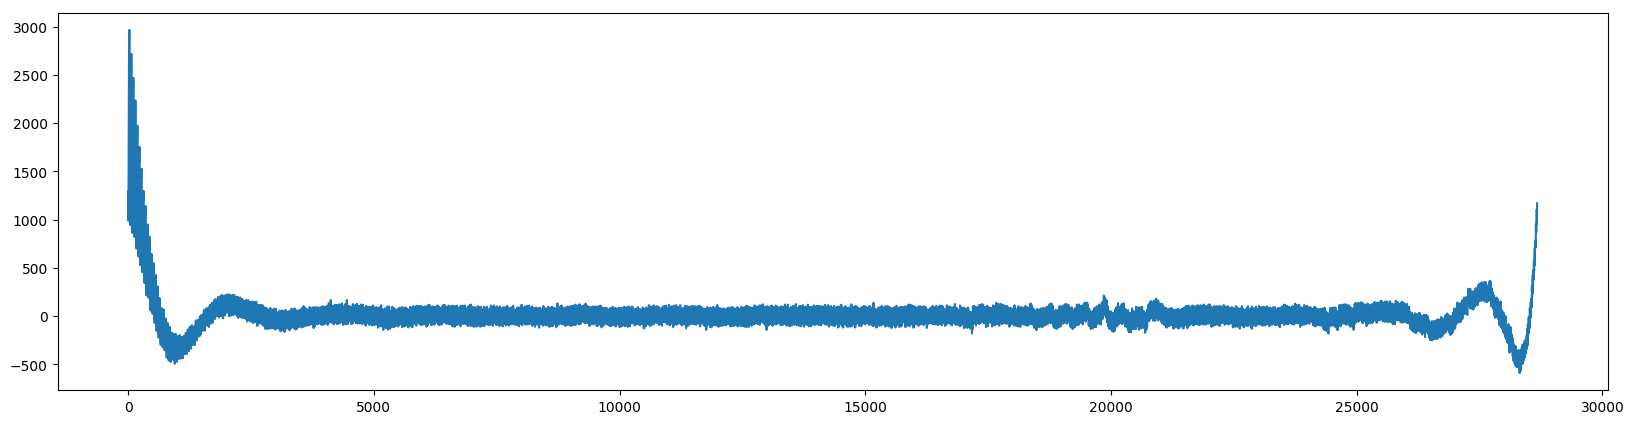

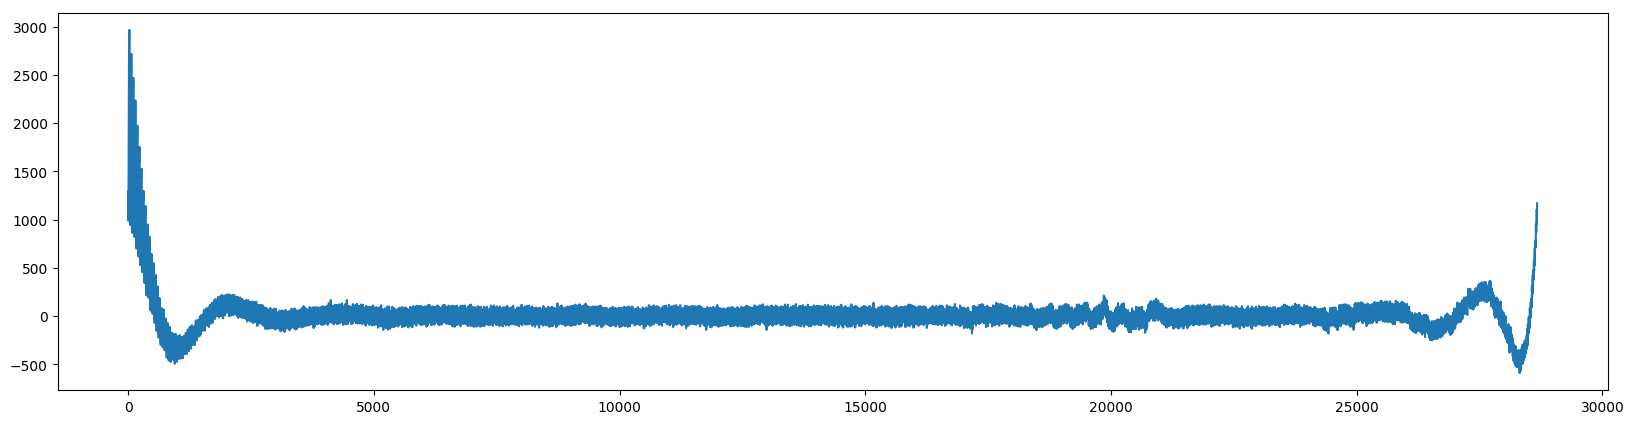

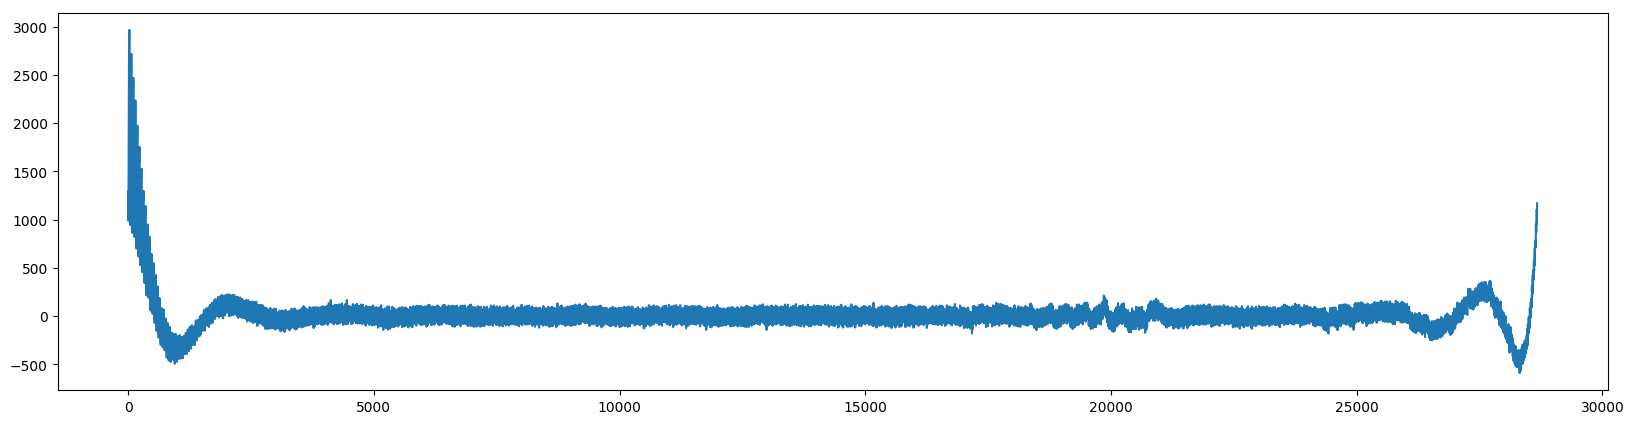

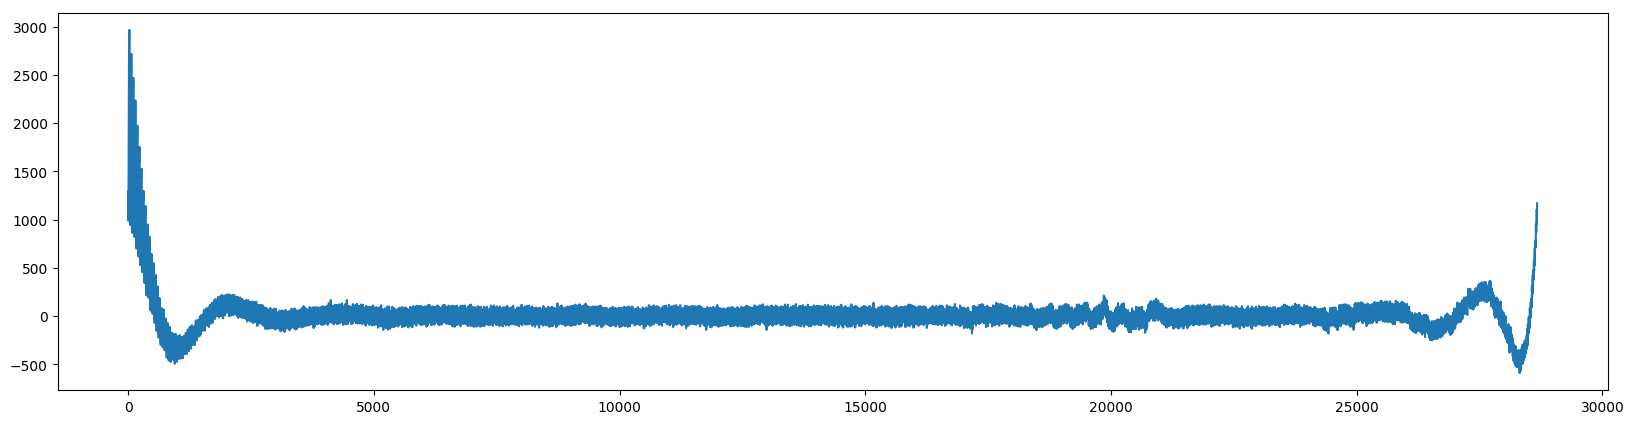

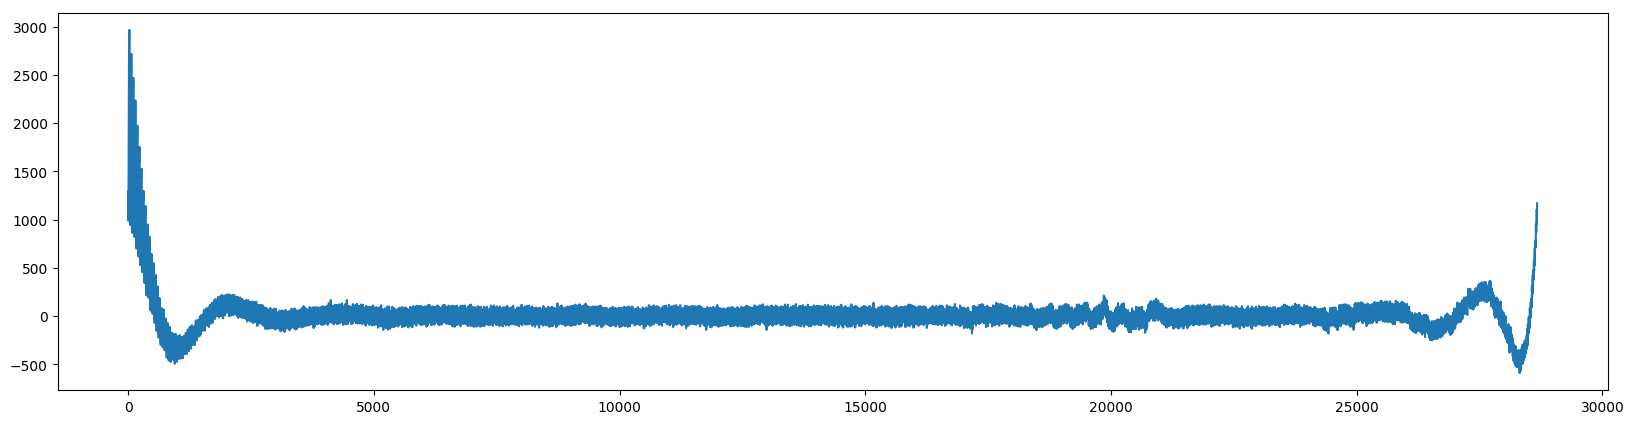

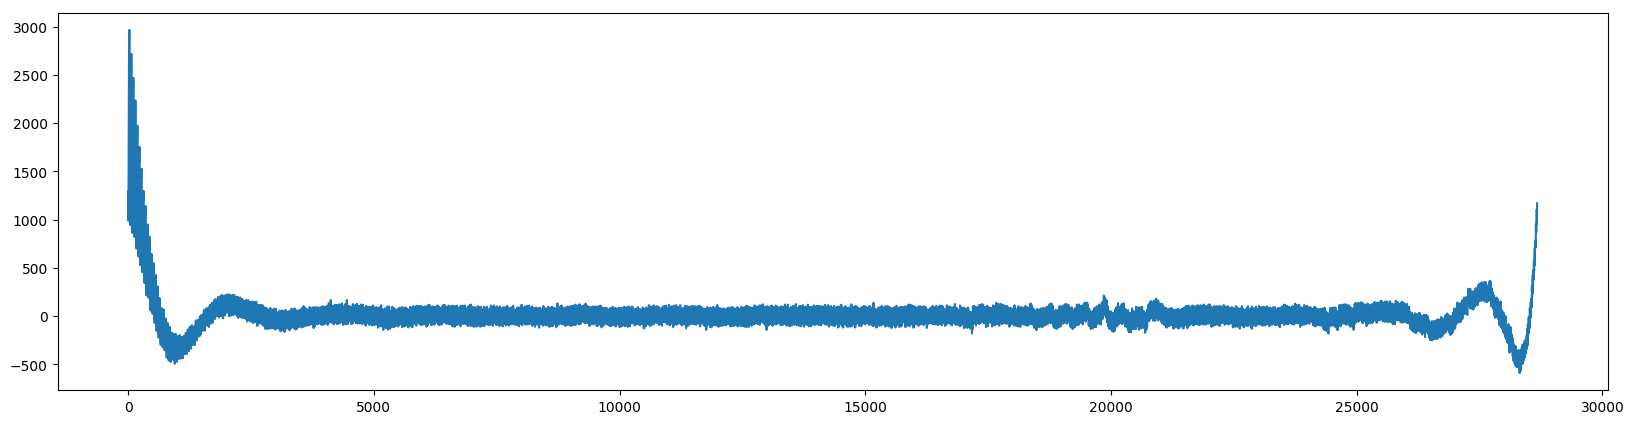

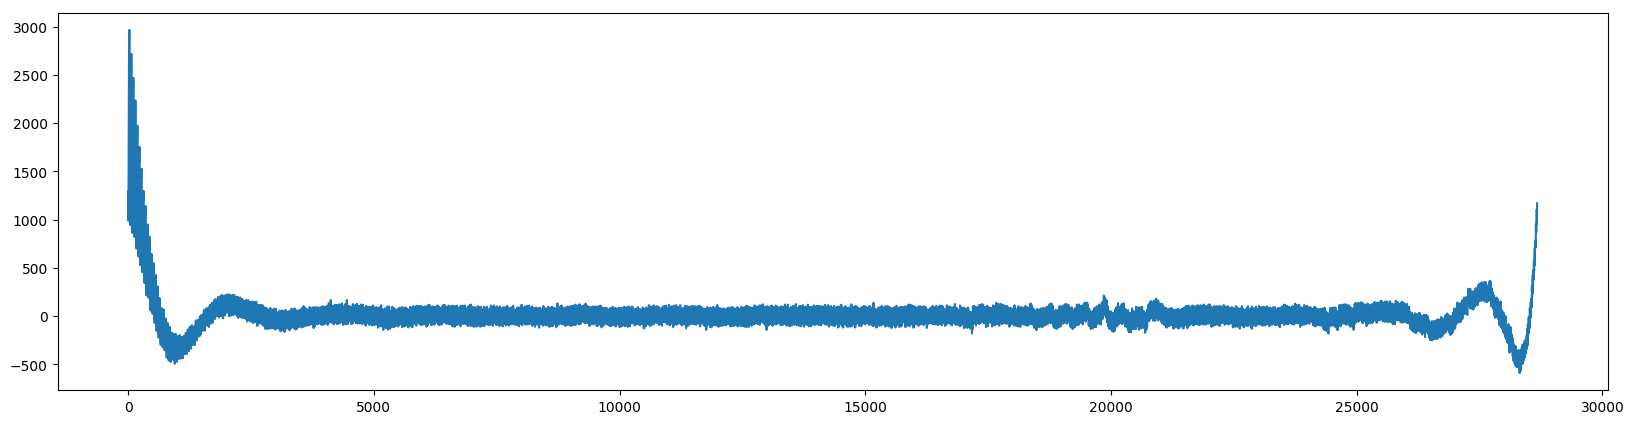

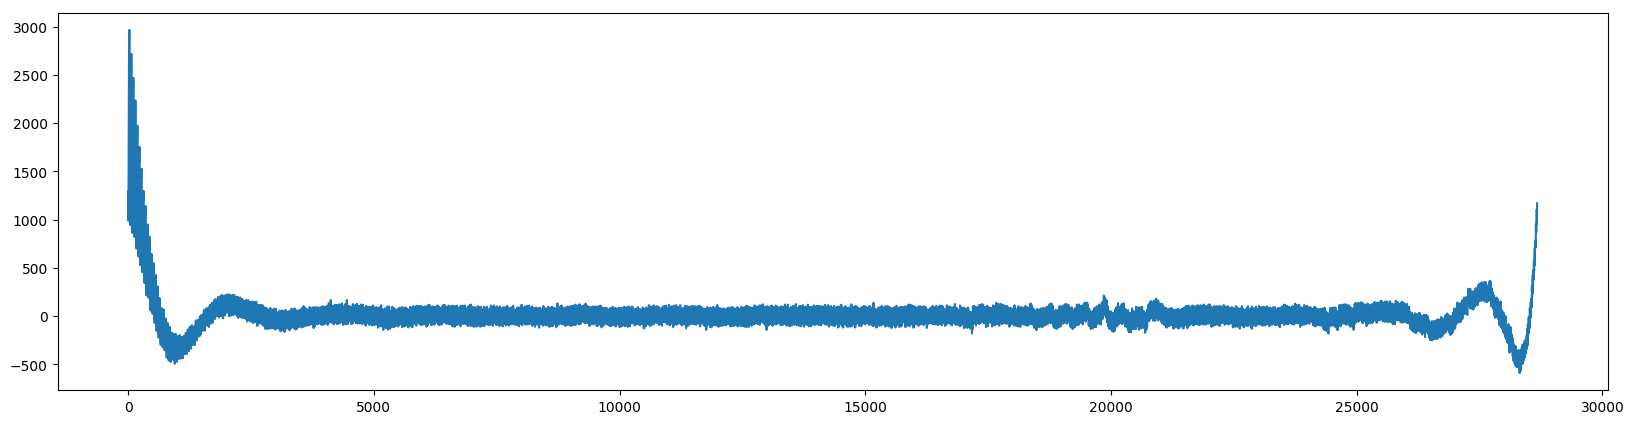

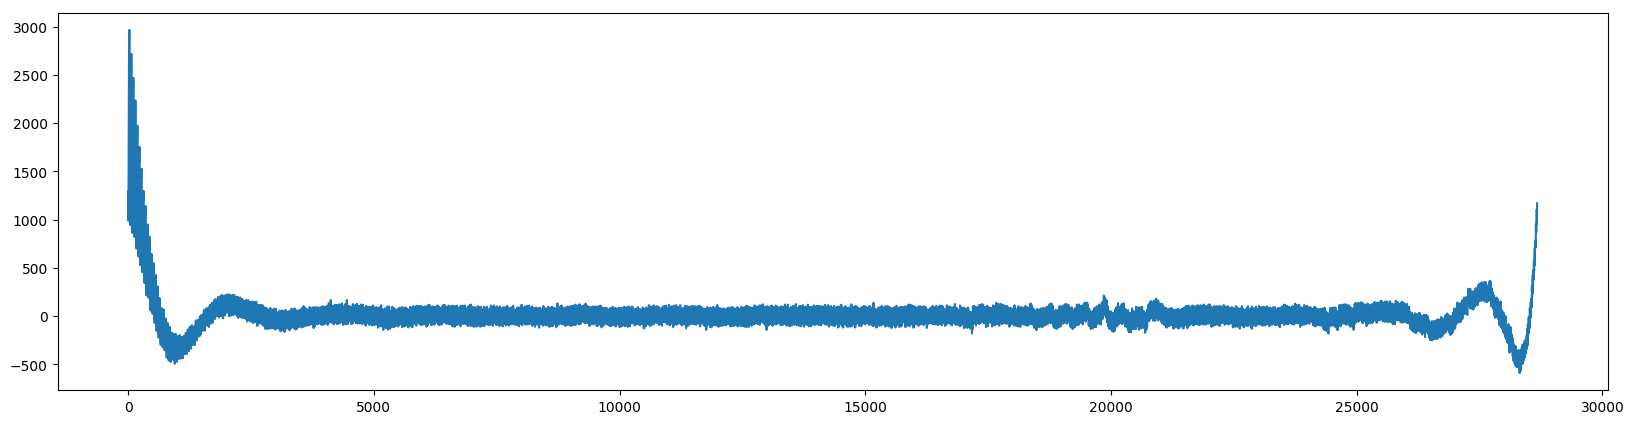

In [8]:
plt.rcParams['figure.figsize'] = [20, 5]
plt.rcParams['figure.dpi'] = 100
#import pandas as pd

#import configparser
#config = configparser.ConfigParser()
#config.read("config.ini")
#Fs = config.get('DEFAULT', 'sampling_rate')
 

#Tworzenie obiektu ReadManager
mgr = ReadManager("mateusz.xml", "mateusz.raw", "mateusz.tag")

#Informacje o sygnale
Fs = float(mgr.get_param("sampling_frequency"))
num_channels = int(mgr.get_param("number_of_channels"))
channel_names = mgr.get_param("channels_names")
gestureDuration = 14 #sekundy
#Gesty
gestures = ['Pytania']
#gestures = gestures.loc[:]['name']
#gestures = gestures.values
gestureID = np.arange(len(gestures))

#długosc wycietego kawalka, 
num_samples = int(gestureDuration * Fs)

# liczba sampli danego gestu
tags = mgr.get_tags()
tag_cnt = {}
for i in mgr.iter_tags():
    k = i['name']
    tag_cnt[k] = int(tag_cnt[k]) + 1 if k in tag_cnt.keys() else 1
gestureSample = max(tag_cnt.values()) 


#Parametry filtrów:
b,a = butter(5, 1/(Fs/2), btype = 'highpass')
d,c = butter(1, np.array([49,51])/(Fs/2), btype = 'bandstop')


#Array do trzymania pociętych danych:
trainData = np.zeros((len(gestureID), gestureSample, num_channels, num_samples))
tmpTrainData = np.zeros((len(gestureID), gestureSample, num_channels, num_samples))

#Ciecie i filtracja:
for j in gestureID:
    k = 0 #Counter dla wypelniania arraya
    #Parametry cięcia
    tag_def = SmartTagDurationDefinition(start_tag_name=gestures[j],
                                     start_offset=0.0,
                                     end_offset=0.0,
                                     duration=gestureDuration)
#    print(gestures[j], gestureID[j])
    smgr = SmartTagsManager(tag_def,
                        "mateusz.xml",
                        "mateusz.raw",
                        "mateusz.tag")
    for i_smart_tag in smgr.iter_smart_tags():
        tmpTrainData[j][k] = i_smart_tag.get_samples()
        for i in range(int((tmpTrainData[j][k].shape[0] - 1))):  #obciecie ostatniego zbednego kanalu i zrobienie bipolarnosci z unipolarnych
            trainData[j][k][i] = tmpTrainData[j][k][i]
        trainData[j][k] = filtfilt(d,c,(filtfilt(b,a,trainData[j][k])))
        k += 1
for i in range(30):
    syg = trainData[0][11][0]
# [b,a] = butter(5, np.array([48, 52])/(Fs/2), btype = 'bandstop')
# syg_filt = filtfilt(b,a,syg)
# [b,a] = butter(5, 0.1/(Fs/2), btype = 'highpass')
# syg_filt = filtfilt(b,a,syg_filt)
    plt.plot(syg)
    plt.show()


# for x in range(2):
#     z = x + 1
#     for k in range(5):        
#         for i in range(10):
#             plot_data = trainData[k][i][x] - trainData[k][i][x][0]
# #             data_set.append(plot_data)
#             plt.subplot(5,2,z)
#             plt.plot(plot_data)
#             plt.title(f'direction:{gestures[k]}, channel:{x}')
#         z = z + 2
# # plt.plot(trainData[0][12][0])
# plt.tight_layout()
# plt.show()